<a href="https://colab.research.google.com/github/EjbejaranosAI/AI_trends_2023/blob/main/MBM_AI_for__analysis_of_brain_image_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AI/ML for the analysis of brain imaging data.
## MBM (Minds, brains and machines)
## Author: Edison Jair Bejarano Sepulveda

### Quantitative susceptibility mapping - QSM DATA from 2018 reconstruction challenge

##### *Download data*

In [1]:
# Downloading data
!wget -nc http://www.neuroimaging.at/media/qsm/20170327_qsm2016_recon_challenge.zip
!unzip -uo 20170327_qsm2016_recon_challenge.zip

--2023-06-07 23:51:13--  http://www.neuroimaging.at/media/qsm/20170327_qsm2016_recon_challenge.zip
Resolving www.neuroimaging.at (www.neuroimaging.at)... 81.19.159.35
Connecting to www.neuroimaging.at (www.neuroimaging.at)|81.19.159.35|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244982259 (234M) [application/zip]
Saving to: ‘20170327_qsm2016_recon_challenge.zip’

20170327_qsm2016_re 100%[===================>] 233.63M  18.7MB/s    in 13s     

2023-06-07 23:51:26 (17.3 MB/s) - ‘20170327_qsm2016_recon_challenge.zip’ saved [244982259/244982259]

Archive:  20170327_qsm2016_recon_challenge.zip
   creating: 20170327_qsm2016_recon_challenge/
   creating: 20170327_qsm2016_recon_challenge/data/
  inflating: 20170327_qsm2016_recon_challenge/data/chi_33.mat  
  inflating: 20170327_qsm2016_recon_challenge/data/chi_33.nii.gz  
  inflating: 20170327_qsm2016_recon_challenge/data/chi_cosmos.mat  
  inflating: 20170327_qsm2016_recon_challenge/data/chi_cosmos.nii.gz  
  infl

##### *Utils functions*

In [15]:
# Importing libraries
import matplotlib.pyplot as plt
from scipy import ndimage
import numpy as np
import nibabel as nib
from matplotlib import transforms
from scipy import ndimage

In [20]:
# Utils functions

#--------------------------#
# Plot view slices brain 3D
#--------------------------#
def view_slices_3d(image_3d, slice_nbr, vmin, vmax, title=''):
    fig = plt.figure(figsize=(12, 6))
    plt.suptitle(title, fontsize=16)
    
    plt.subplot(131)
    image = np.take(image_3d, slice_nbr, 2)
    plt.imshow(image, vmin=vmin, vmax=vmax, cmap='gray')
    plt.title('Axial')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    
    plt.subplot(132)
    image_rot = ndimage.rotate(np.take(image_3d, slice_nbr, 1),90)
    plt.imshow(image_rot, vmin=vmin, vmax=vmax, cmap='gray')
    plt.title('Coronal')
    plt.xlabel('X-axis')
    plt.ylabel('Z-axis')
    
    plt.subplot(133)
    image_rot = ndimage.rotate(np.take(image_3d, slice_nbr, 0),90)
    plt.imshow(image_rot, vmin=vmin, vmax=vmax, cmap='gray')
    plt.title('Sagittal')
    plt.xlabel('Y-axis')
    plt.ylabel('Z-axis')
    
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Intensity', rotation=270, labelpad=15)
    
    plt.tight_layout()
    plt.show()


def simulate_susceptibility_sources(simulation_dim = 160,
                                    rectangles_total = 100, 
                                    shperes_total = 80, 
                                    sus_std = 1,
                                    shape_size_min_factor= 0.01,
                                    shape_size_max_factor = 0.5):
  
  temp_sources = np.zeros((simulation_dim, simulation_dim, simulation_dim))

  for shapes in range(rectangles_total):
    shrink_factor = 1/((shapes/rectangles_total+1))
    shape_size_min = np.floor(simulation_dim * shrink_factor * shape_size_min_factor)
    shape_size_max = np.floor(simulation_dim * shrink_factor * shape_size_max_factor)
    print(f"\n ------- Shape Min size: {shape_size_min} ------- \n")
    print(f"\n ------- Shape Max size: {shape_size_max} ------- \n")

    susceptibility_value = np.random.normal(loc=0.0, scale=sus_std)


##### Images exploration by views

<ipython-input-21-b42306d4fe86>:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  tissue_phase_brain = nib.load('/content/20170327_qsm2016_recon_challenge/data/phs_tissue.nii.gz').get_data()
<ipython-input-21-b42306d4fe86>:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  gold_standard_qsm = nib.load('/content/20170327_qsm2016_recon_challenge/data/chi_33.nii.gz').get_data()


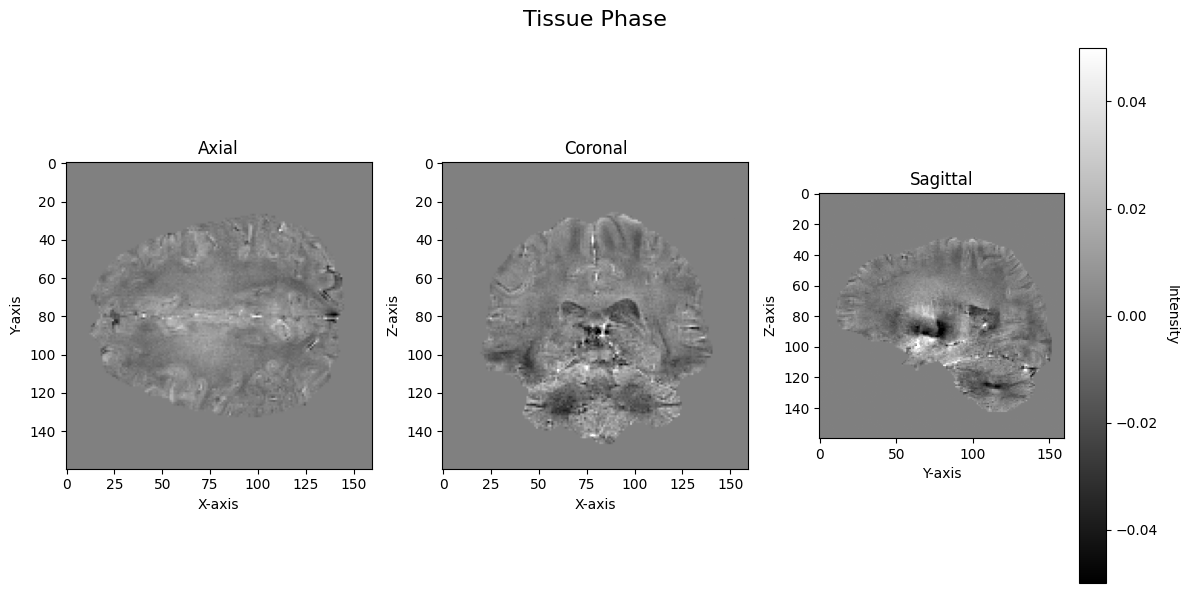

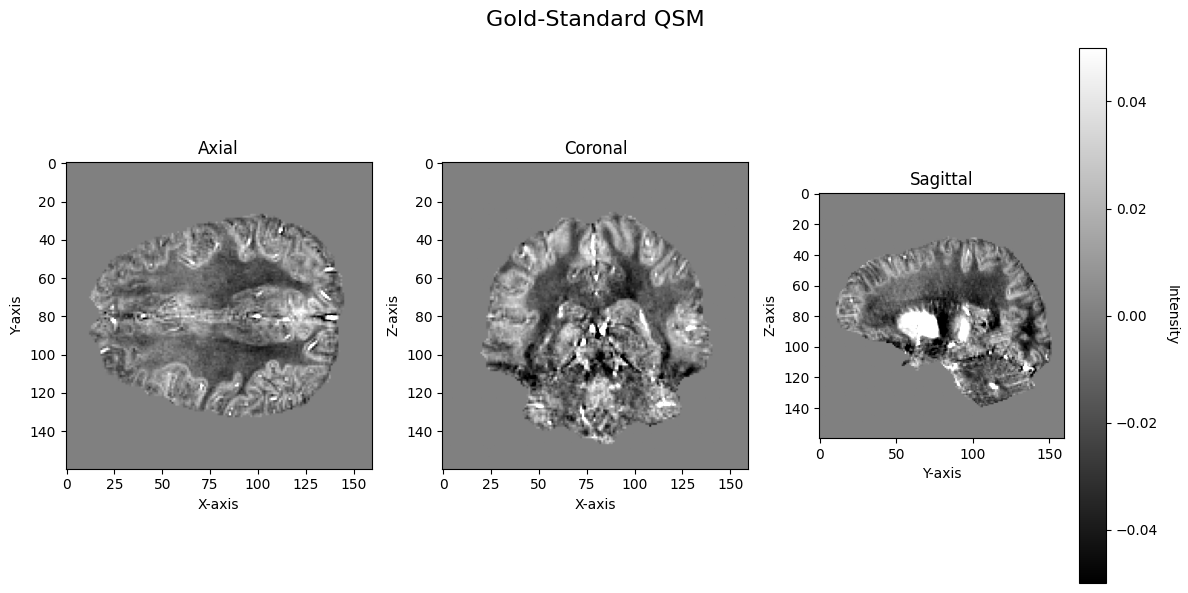

In [21]:
# Loading images by nib library
tissue_phase_brain = nib.load('/content/20170327_qsm2016_recon_challenge/data/phs_tissue.nii.gz').get_data()
gold_standard_qsm = nib.load('/content/20170327_qsm2016_recon_challenge/data/chi_33.nii.gz').get_data()


view_slices_3d(tissue_phase_brain, slice_nbr=100, vmin=-0.05, vmax=0.05, title='Tissue Phase')
view_slices_3d(gold_standard_qsm, slice_nbr=100, vmin=-0.05, vmax=0.05, title='Gold-Standard QSM') 